# ICU Occupancy Forecast with Prophet (COVID-19, Italy)

## Install commands

In [1]:
#!pip install prophet
#!pip install scikit-learn
#!pip install statsmodels
#!pip install pmdarima
# !pip uninstall -y numpy
# !pip install numpy==1.24.4
# !pip install --force-reinstall --no-cache-dir pmdarima

## Set - up

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")  # ignoro warning ARIMA inutili
from statsmodels.tsa.statespace.sarimax import SARIMAX 

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Parameters

In [ ]:
URL_DATA   = ("https://raw.githubusercontent.com/pcm-dpc/COVID-19/"
              "master/dati-regioni/dpc-covid19-ita-regioni.csv")

USE_REGION = True                       # False ➜ aggregate Italy
REGIONE    = "Lombardia"                # used only if USE_REGION = True
POSTI_TI   = 1200                       # ICU bed capacity for the region
HORIZON    = 120                         # forecast horizon (days)

LAG_POS    = 6                         # days between positives ➜ ICU stock
LAG_ING    = 3                          # days between ICU admissions ➜ stock
ROLL_WIN   = 3                          # rolling median window for smoothing

## LAG test

In [4]:
# from tqdm import tqdm
# from prophet import Prophet

# def test_lag_combinations(df, lag_pos_values, lag_ing_values, horizon=30, posti_ti=1200):
#     results = []

#     for lag_pos in tqdm(lag_pos_values, desc="Lag Pos"):
#         for lag_ing in lag_ing_values:
#             df_copy = df.copy()

#             # Applichiamo lag
#             df_copy[f'nuovi_pos_lag{lag_pos}'] = df_copy['nuovi_positivi'].shift(lag_pos)
#             df_copy[f'ingressi_ti_lag{lag_ing}'] = df_copy['ingressi_terapia_intensiva'].shift(lag_ing)

#             # Target + bounds
#             df_copy['y'] = df_copy['terapia_intensiva'].rolling(3, center=True).median().bfill()
#             df_copy['cap'] = posti_ti
#             df_copy['floor'] = 0

#             df_copy = df_copy.dropna()

#             required_cols = ['ds', 'y']
#             missing = [col for col in required_cols if col not in df_copy.columns]
#             if missing:
#                 print(f"Salto combinazione lag_pos={lag_pos}, lag_ing={lag_ing}: mancano colonne {missing}")
#                 continue

#             if len(df_copy) < horizon + 1:
#                 print(f"Salto combinazione lag_pos={lag_pos}, lag_ing={lag_ing}: dataset troppo corto ({len(df_copy)} righe).")
#                 continue

#             try:
#                 train = df_copy.iloc[:-horizon]
#                 test = df_copy.iloc[-horizon:]

#                 m = Prophet(growth='logistic')
#                 m.add_regressor(f'nuovi_pos_lag{lag_pos}')
#                 m.add_regressor(f'ingressi_ti_lag{lag_ing}')
#                 m.fit(train)

#                 future = test[['ds', f'nuovi_pos_lag{lag_pos}', f'ingressi_ti_lag{lag_ing}']].copy()
#                 future['cap'] = posti_ti
#                 future['floor'] = 0

#                 forecast = m.predict(future)
#                 mae = mean_absolute_error(test['y'], forecast['yhat'])
#                 results.append((lag_pos, lag_ing, mae))
#             except Exception as e:
#                 print(f"Errore con lag_pos={lag_pos}, lag_ing={lag_ing}: {e}")

#     return sorted(results, key=lambda x: x[2])


## Data

In [5]:
df = pd.read_csv(URL_DATA, parse_dates=["data"]).sort_values("data")

if USE_REGION:
    df = df.query("denominazione_regione == @REGIONE").copy()
else:                                   # aggregate over Italy
    df = (df.groupby("data", as_index=False)
            .agg({"terapia_intensiva": "sum",
                  "nuovi_positivi": "sum",
                  "ingressi_terapia_intensiva": "sum"}))
    REGIONE = "Italia"
    POSTI_TI = int(df["terapia_intensiva"].max() * 1.3)  # rough cap


## descrizione dataset

In [6]:
variabili = ["totale_positivi", "ingressi_terapia_intensiva", "ricoverati_con_sintomi"]
stats = df[variabili].agg(["min", "max", "mean"]).T
stats.columns = ["Valore Minimo", "Valore Massimo", "Media"]
stats.index.name = "Variabile"


print("Statistiche descrittive (Regione Lombardia):")
display(stats.round(2))

KeyError: "['totale_positivi', 'ricoverati_con_sintomi'] not in index"

## LAG Optimization

In [ ]:
# df_raw = pd.read_csv(URL_DATA, parse_dates=["data"]).sort_values("data")
# df_raw = df_raw[df_raw["denominazione_regione"] == "Lombardia"].copy()

# # Mantieni solo le colonne utili
# df_raw = df_raw[["data", "terapia_intensiva", "nuovi_positivi", "ingressi_terapia_intensiva"]].copy()
# df_raw = df_raw.rename(columns={"data": "ds"})


# # Definizione degli intervalli di lag da testare
# lag_pos_range = range(2, 10)
# lag_ing_range = range(2, 7)

# # Esegui la ricerca dei lag ottimali
# risultati = test_lag_combinations(df_raw, lag_pos_range, lag_ing_range, horizon=30, posti_ti=POSTI_TI)

# # Mostra i 5 migliori
# print("\nMigliori combinazioni trovate:")
# for r in risultati[:5]:
#     print(f"LAG_POS={r[0]}, LAG_ING={r[1]}, MAE={r[2]:.2f}")
# pd.DataFrame(risultati, columns=["LAG_POS", "LAG_ING", "MAE"]).to_csv("Outputs/risultati_lag.csv", index=False)

    

## Pre-processing

In [ ]:
df = df.rename(columns={"data": "ds"})
df["y"] = (df["terapia_intensiva"]
             .rolling(ROLL_WIN, center=True)
             .median()
             .bfill())
#----ARIMA-----
# Serie storica completa della variabile target
serie_ti = df[["ds", "terapia_intensiva"]].copy()
serie_ti['y'] = serie_ti['terapia_intensiva'].rolling(window=3).mean().bfill()
serie_ti = serie_ti.dropna()
serie_ti = serie_ti.set_index("ds")["y"]

In [ ]:
# Lagged regressors
df[f"nuovi_pos_lag{LAG_POS}"]    = df["nuovi_positivi"].shift(LAG_POS)
df[f"ingressi_ti_lag{LAG_ING}"]  = df["ingressi_terapia_intensiva"].shift(LAG_ING)
df[f"ricoverati_con_sintomi_lag{LAG_ING}"]  = df["ricoverati_con_sintomi"].shift(LAG_ING)

df["positivi_lag"]=df["totale_positivi"].shift(LAG_POS)
df["ingressi_lag"]=df["ingressi_terapia_intensiva"].shift(LAG_ING)
df_model = df[["ds", "terapia_intensiva", "positivi_lag", "ingressi_lag"]].copy()
df_model = df_model.rename(columns={"data": "ds", "terapia_intensiva": "y"})
df_model["cap"] = POSTI_TI
df_model = df_model.dropna()

#-- ARIMA---
# Regressori per SARIMAX (che sarebbe arima con regreesori )
df_arima = df[['ds', 'terapia_intensiva', f'nuovi_pos_lag{LAG_POS}', f'ingressi_ti_lag{LAG_ING}']].copy()
df_arima['y'] = df_arima['terapia_intensiva'].rolling(window=3).mean().bfill()
df_arima = df_arima.dropna()
df_arima = df_arima.set_index('ds')[['y', f'nuovi_pos_lag{LAG_POS}', f'ingressi_ti_lag{LAG_ING}']]


In [ ]:
df["cap"]   = POSTI_TI           # upper bound for logistic growth
df["floor"] = 0
df = df[["ds", "y", f"nuovi_pos_lag{LAG_POS}", f"ingressi_ti_lag{LAG_ING}", f"ricoverati_con_sintomi_lag{LAG_ING}", "cap", "floor", "nuovi_positivi", "ingressi_terapia_intensiva", "ricoverati_con_sintomi"]]
df = df.dropna().reset_index(drop=True)

In [ ]:
df.sort_values("ds", ascending=False).head()


,ds,y,nuovi_pos_lag6,ingressi_ti_lag3,ricoverati_con_sintomi_lag3,cap,floor,nuovi_positivi,ingressi_terapia_intensiva,ricoverati_con_sintomi
1493,2025-01-07 17:00:00,4.0,67.0,1.0,96.0,1200,0,39,0.0,98
1492,2025-01-06 17:00:00,4.0,119.0,1.0,86.0,1200,0,32,0.0,100
1491,2025-01-05 17:00:00,4.0,33.0,0.0,78.0,1200,0,46,0.0,98
1490,2025-01-04 17:00:00,5.0,38.0,0.0,77.0,1200,0,72,1.0,96
1489,2025-01-03 17:00:00,5.0,92.0,1.0,86.0,1200,0,88,1.0,86


## Ricerca automatica parametri SARIMAX

In [ ]:
# # Ricerca automatica dei migliori parametri (p,d,q)

# # Divisione train/test coerente con Prophet
# X = df_arima[[f'nuovi_pos_lag{LAG_POS}', f'ingressi_ti_lag{LAG_ING}']]
# y = df_arima['y']
# X_train, X_test = X[:-HORIZON], X[-HORIZON:]
# y_train, y_test = y[:-HORIZON], y[-HORIZON:]

# p_values = range(0, 3)
# d_values = range(0, 2)
# q_values = range(0, 3)

# best_order = None
# best_mae = float("inf")

# for p in p_values:
#     for d in d_values:
#         for q in q_values:
#             try:
#                 model = SARIMAX(y_train, exog=X_train, order=(p, d, q))
#                 results = model.fit(disp=False)
#                 preds = results.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)
#                 mae = mean_absolute_error(y_test, preds)

#                 if mae < best_mae:
#                     best_mae = mae
#                     best_order = (p, d, q)
#             except:
#                 continue

# print(f"Miglior combinazione trovata: ARIMA{best_order} con MAE = {best_mae:.2f}")

# # Salvataggio del risultato in un file CSV
# mae_results_df = pd.DataFrame({
#     "Modello": ["SARIMAX"],
#     "Parametro_p": [best_order[0]],
#     "Parametro_d": [best_order[1]],
#     "Parametro_q": [best_order[2]],
#     "MAE": [best_mae]
# })
# mae_results_df.to_csv("Outputs/mae_sarimax.csv", index=False)

## Model training

In [ ]:
train, test = df.iloc[:-HORIZON], df.iloc[-HORIZON:]

m = Prophet(
    growth="logistic",
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False,
    seasonality_mode="additive",
    changepoint_prior_scale=0.05
)

m.add_regressor(f"nuovi_pos_lag{LAG_POS}", prior_scale=5)
m.add_regressor(f"ingressi_ti_lag{LAG_ING}", prior_scale=5)
m.add_regressor(f"ricoverati_con_sintomi_lag{LAG_ING}", prior_scale=5)

m.fit(train)

#-----ARIMA------

# Divisione train/test coerente con Prophet
X = df_arima[[f'nuovi_pos_lag{LAG_POS}', f'ingressi_ti_lag{LAG_ING}']]
y = df_arima['y']
X_train, X_test = X[:-HORIZON], X[-HORIZON:]
y_train, y_test = y[:-HORIZON], y[-HORIZON:]


# SARIMAX = ARIMA con regressori
best_order = (2,0,2)

model_sarimax = SARIMAX(y_train, exog=X_train, order=best_order)

#model_sarimax = SARIMAX(y_train, exog=X_train, order=(2,1,2))#(2,1,2)(1,0,3))

fit_sarimax = model_sarimax.fit(disp=False)

# Forecast SARIMSX
forecast_sarimax = fit_sarimax.forecast(steps=HORIZON, exog=X_test)
# Previsione completa dal 2021 (fitted + forecast)
sarimax_fitted = fit_sarimax.fittedvalues
sarimax_full = pd.concat([sarimax_fitted, forecast_sarimax])


# confronto MAE
mae_sarimax = mean_absolute_error(y_test, forecast_sarimax)
print(f"MAE modello SARIMAX (cioè con regressori): {mae_sarimax:.2f}")


22:55:28 - cmdstanpy - INFO - Chain [1] start processing
22:55:28 - cmdstanpy - INFO - Chain [1] done processing


MAE modello SARIMAX (cioè con regressori): 5.25


## Prediction

In [ ]:
future = m.make_future_dataframe(periods=5000)
future["cap"] = POSTI_TI
future["floor"]=0
print(future.head())

#  Re-merge to compute lag features on the extended range
full = (pd.concat([df, future], ignore_index=True)
          .sort_values("ds")
          .reset_index(drop=True))

full[f"nuovi_pos_lag{LAG_POS}"]   = full["nuovi_positivi"].shift(LAG_POS)
full[f"ingressi_ti_lag{LAG_ING}"] = full["ingressi_terapia_intensiva"].shift(LAG_ING)
full[f"ricoverati_con_sintomi_lag{LAG_ING}"] = full["ricoverati_con_sintomi"].shift(LAG_ING)
full["cap"]   = POSTI_TI
full["floor"] = 0
future = full.loc[future.index]    # keep only rows Prophet needs
future = future.dropna().reset_index(drop=True)

forecast = m.predict(future)

# Calcolo % di occupazione (pct_occ) rispetto alla capacità
forecast['pct_occ'] = forecast['yhat'] / POSTI_TI * 100
forecast['over70'] = forecast['pct_occ'] >= 70
forecast['over80'] = forecast['pct_occ'] >= 80
forecast['over85'] = forecast['pct_occ'] >= 85
#quin stampo il numero di volte in cui supero le soglie
for soglia in [70, 80, 85]:
    sopra_soglia = forecast[forecast['pct_occ'] >= soglia]
    if not sopra_soglia.empty:
        print(f"Oltre {soglia}% per {len(sopra_soglia)} giorni, primo superamento: {sopra_soglia['ds'].iloc[0].date()}")
    else:
        print(f"Nessun superamento del {soglia}%")


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'pct_occ', 'over70', 'over80', 'over85']].to_csv("Outputs/forecasts_con_saturazione.csv",
    index=False) #Salvo le saturazioi in CSV
forecast.to_csv("Outputs/previsioni_prophet.csv", index=False) #Salvo le previsioni in CSV

forecast_sarimax_df = pd.DataFrame({
    "ds": y_test.index,
    "y_reale": y_test.values,
    "y_previsto_sarimax": forecast_sarimax.values
})

forecast_sarimax_df.to_csv("Outputs/previsioni_sarimax.csv", index=False)


                   ds   cap  floor
0 2020-12-06 17:00:00  1200      0
1 2020-12-07 17:00:00  1200      0
2 2020-12-08 17:00:00  1200      0
3 2020-12-09 17:00:00  1200      0
4 2020-12-10 17:00:00  1200      0
Oltre 70% per 2 giorni, primo superamento: 2021-03-24
Nessun superamento del 80%
Nessun superamento del 85%
2024-09-11 17:00:00
2025-01-08 17:00:00
False


## Prophet vs Dummy in a specific date

In [ ]:
data_scelta = y_test.index[0] #uso la 1 data del traingn set

# Estrai i valori
y_reale = y_test.loc[data_scelta]
y_prophet = forecast.set_index("ds").loc[data_scelta, "yhat"]
y_dummy = y_train.mean()

# Tabella con valori arrotondati, lo faccio perche è utile per la tesi
df_arrotondato = pd.DataFrame({
    "Data": [data_scelta.strftime("%Y-%m-%d")],
    "Valore reale": [round(y_reale)],
    "Previsione Prophet": [round(y_prophet)],
    "Previsione Dummy": [round(y_dummy)],
    "Errore Prophet": [round(abs(y_reale - y_prophet))],
    "Errore Dummy": [round(abs(y_reale - y_dummy))]
})

print("\nTabella arrotondata per la tesi:")
display(df_arrotondato)




Tabella arrotondata per la tesi:


,Data,Valore reale,Previsione Prophet,Previsione Dummy,Errore Prophet,Errore Dummy
0,2024-09-11,4,15,102,11,97


## Forecast's check

 1. Statistiche descrittive - Test vs Previsione
                        ds           y
count                  120  120.000000
mean   2024-11-09 05:00:00    8.600000
min    2024-09-10 17:00:00    1.000000
25%    2024-10-10 11:00:00    4.750000
50%    2024-11-09 05:00:00   10.000000
75%    2024-12-08 23:00:00   12.000000
max    2025-01-07 17:00:00   14.000000
std                    NaN    4.106564
                                  ds        yhat
count                            323  323.000000
mean   2022-11-15 16:15:25.077399296  109.320481
min              2020-12-09 17:00:00  -27.531043
25%              2021-12-09 05:00:00    1.529817
50%              2022-10-24 17:00:00   37.121694
75%              2023-11-14 05:00:00  102.972302
max              2025-01-06 17:00:00  897.690858
std                              NaN  189.031916

 2. Verifica NaN nei regressori usati dal test set
nuovi_pos_lag6      0
ingressi_ti_lag3    0
dtype: int64

 3. Plot: Reale vs Previsione


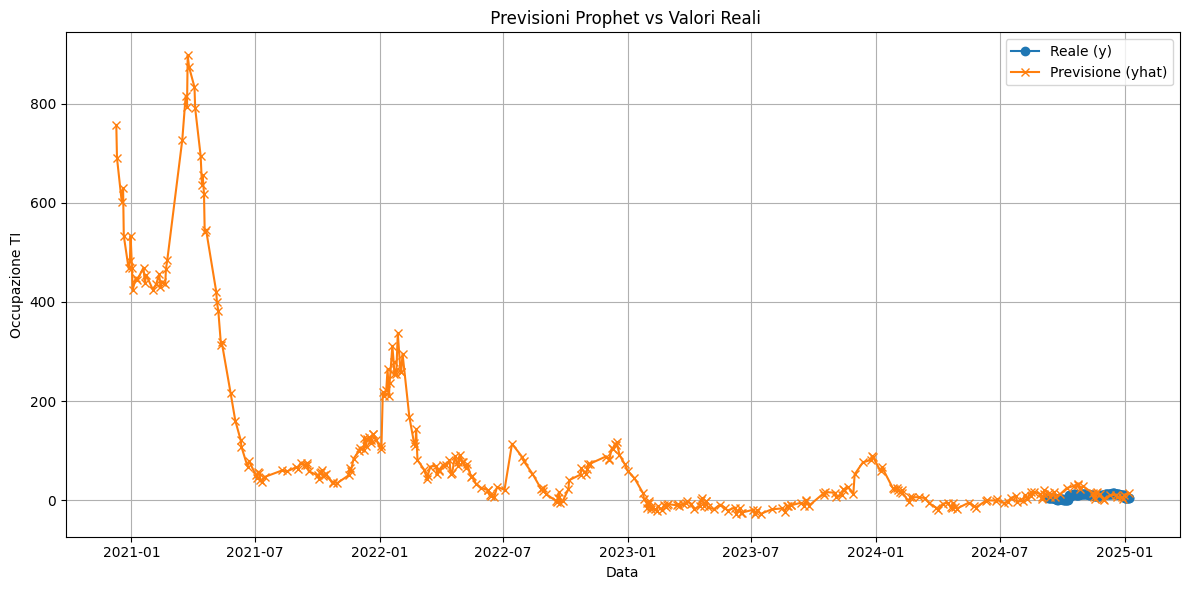


 4. Confronto con modello dummy (media del training)
MAE modello Prophet: 8.70
MAE modello dummy (media): 92.62
MAE Dummy (media): 93.13
MAE modello SARIMAX: 5.25


In [ ]:
print(" 1. Statistiche descrittive - Test vs Previsione")#-------------
print(test[['ds', 'y']].describe())
print(forecast[['ds', 'yhat']].describe())

print("\n 2. Verifica NaN nei regressori usati dal test set")
print(test[[f'nuovi_pos_lag{LAG_POS}', f'ingressi_ti_lag{LAG_ING}']].isna().sum())

print("\n 3. Plot: Reale vs Previsione")#-------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test['ds'], test['y'], label='Reale (y)', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Previsione (yhat)', marker='x')
plt.title(" Previsioni Prophet vs Valori Reali")
plt.xlabel("Data")
plt.ylabel("Occupazione TI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n 4. Confronto con modello dummy (media del training)")#-------------
y_mean = train['y'].mean()
# Merge per confronto corretto
merged = pd.merge(test[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')
# Calcolo MAE
mae_model = mean_absolute_error(merged['y'], merged['yhat'])
mae_dummy = mean_absolute_error(test['y'], [y_mean]*len(test))
print(f"MAE modello Prophet: {mae_model:.2f}")
print(f"MAE modello dummy (media): {mae_dummy:.2f}")

mae_sarimax = mean_absolute_error(y_test, forecast_sarimax)
y_mean = y_train.mean()
mae_dummy_arima = mean_absolute_error(y_test, [y_mean]*len(y_test))
print(f"MAE Dummy (media): {mae_dummy_arima:.2f}")
print(f"MAE modello SARIMAX: {mae_sarimax:.2f}")

mae_df = pd.DataFrame({
    "Modello": ["Prophet", "Dummy Prophet", "SARIMAX", "Dummy SARIMAX"],
    "MAE": [mae_model, mae_dummy, mae_sarimax, mae_dummy_arima]
})
mae_df.to_csv("Outputs/mae_confronto_dummy.csv", index=False)


# Plot

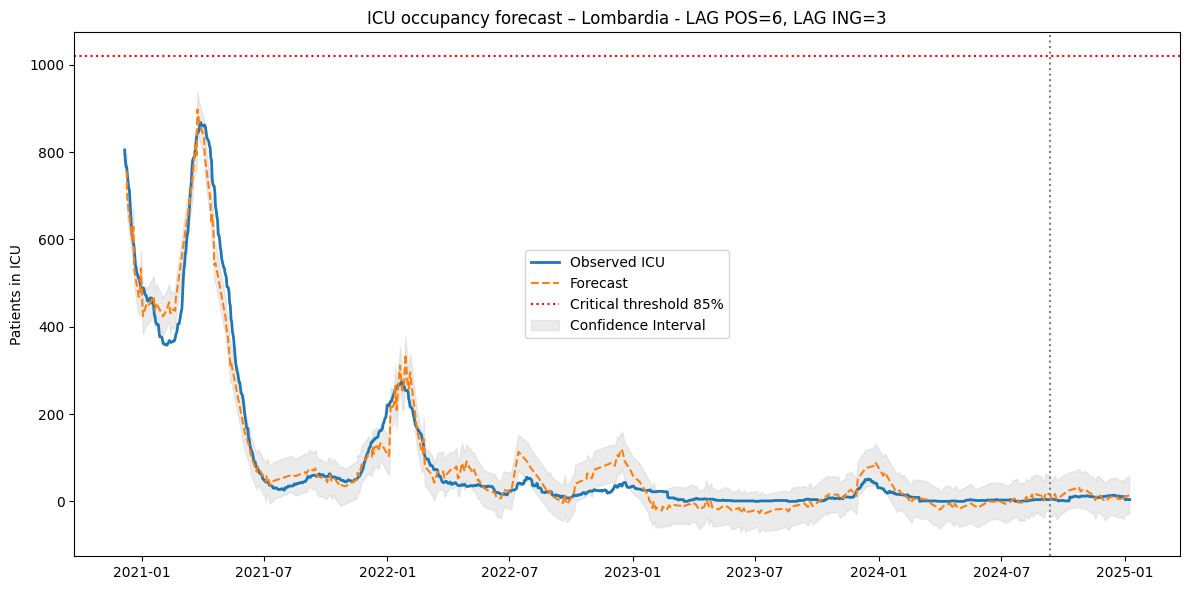

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df["ds"], df["y"], label="Observed ICU", linewidth=2)
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", linestyle="--")
plt.axvline(test["ds"].min(), color="gray", linestyle=":")
# Soglia critica
plt.axhline((POSTI_TI*85)/100, color='red', linestyle=':', label='Critical threshold 85%')
plt.title(f"ICU occupancy forecast – {REGIONE} - LAG POS={LAG_POS}, LAG ING={LAG_ING}")
plt.ylabel("Patients in ICU")
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#C0C0C0', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.tight_layout()
plt.show()

## Comparison

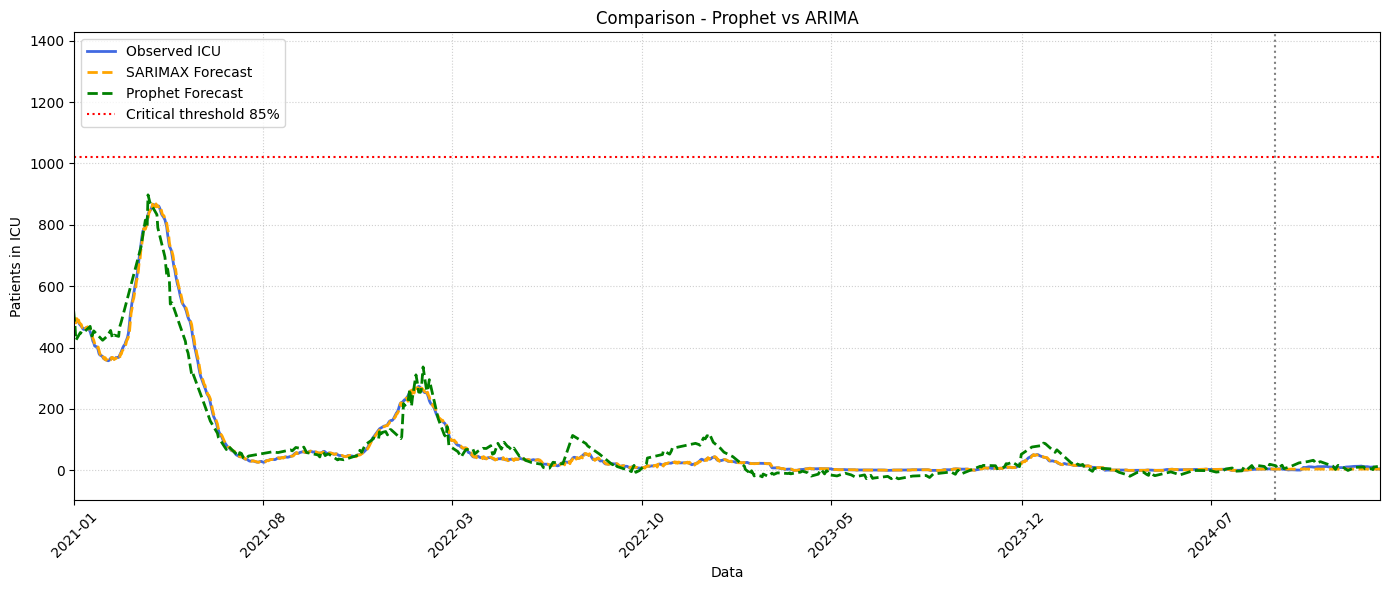

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14,6))
plt.axvline(test["ds"].min(), color="gray", linestyle=":")

# Storico completo (per contesto)
plt.plot(serie_ti.index, serie_ti.values, label='Observed ICU', color='royalblue', linewidth=2)

# ARIMA 
plt.plot(sarimax_full.index, sarimax_full.values, label='SARIMAX Forecast', linestyle='--', color='orange', linewidth=2)

# Prophet
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--', color='green', linewidth=2)

# Soglia 85%
plt.axhline(POSTI_TI * 0.85, linestyle=':', color='red', label='Critical threshold 85%')

# Asse X e layout
plt.title("Comparison - Prophet vs ARIMA")
plt.xlabel("Data")
plt.ylabel("Patients in ICU")
plt.grid(True, linestyle=':', alpha=0.6)
plt.xlim([pd.to_datetime("2021-01-01"), forecast['ds'].max()])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=7))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
